# Прогнозирование заказов такси

**Цель проекта:**  
Разработать модель машинного обучения для предсказания количества заказов такси в аэропорту на следующий час. Это позволит компании «Чётенькое такси» оптимизировать распределение водителей в периоды пиковой нагрузки и улучшить качество обслуживания клиентов.

**Описание проекта:**  
Компания «Чётенькое такси» собирает данные о заказах такси, сделанных в аэропортах. На основе исторических данных необходимо предсказать количество заказов такси на следующий час. Построенная модель будет использоваться для оптимизации распределения водителей и повышения качества обслуживания в пиковые часы. Ключевая метрика — RMSE, значение которой должно быть не больше 48.

**Критерии, важные заказчику:**  
- Высокая точность предсказания (метрика RMSE на тестовой выборке не более 48).
- Оптимизация времени обучения модели.
- Возможность работы с историческими данными для корректного прогнозирования.

---

**Этапы выполнения проекта:**

**1. Загрузка и анализ данных**  
- Загрузить данные из файла `/datasets/taxi.csv`.
- Ознакомиться с общей структурой данных: столбцы, типы признаков, распределение данных.
- Проверить наличие пропусков, выбросов и аномалий в данных.

**2. Предобработка данных**  
- Привести данные к необходимому формату: выполнить ресемплирование данных по одному часу для временного ряда.

**3. Разделение данных**  
- Определить целевой признак (`num_orders`).
- Разделить выборку на обучающую и тестовую: тестовая выборка — 10% от всех данных.

**4. Построение и обучение моделей**  
- Создать pipeline для обработки данных и обучения моделей.
- Обучить несколько моделей, используя различные алгоритмы:
  - Линейная регрессия (`LinearRegression`).
  - Решающее дерево (`DecisionTreeRegressor`).
  - Случайный лес (`RandomForestRegressor`).
- Настроить гиперпараметры моделей с использованием `GridSearchCV` или `RandomizedSearchCV`.

**5. Оценка моделей**  
- Оценить каждую модель по метрике RMSE на тестовой выборке.
- Проанализировать:
  - Время обучения каждой модели.
  - Время предсказания для каждой модели.
  - Качество предсказаний (на основе RMSE и визуализации ошибок).

**6. Выбор лучшей модели и финальное тестирование**  
- Выбрать модель с наилучшей метрикой RMSE и оптимальной скоростью работы.

## Подготовка данных

### Загрузка данных

In [264]:
# Базовые библиотеки
import os, time, sklearn, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Модели и обработка данных
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit 
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

# Метрики
from sklearn.metrics import mean_squared_error

# Тесты на нормальность распределения
from scipy.stats import shapiro, normaltest, kstest

# Константы
RANDOM_STATE = 42


In [265]:
# Загрузка данных с учетом разделителей
path = 'taxi/taxi.csv'
if os.path.exists(path):
    taxi = pd.read_csv(path, delimiter=',')
else: print('Не получилось найти файл по указанному пути')

In [266]:
# Преобразование столбца 'datetime' в формат datetime
taxi['datetime'] = pd.to_datetime(taxi['datetime'])

# Установка 'datetime' как индекс
taxi.set_index('datetime', inplace=True)

# Сортировка датасета по индексу (дата)
taxi = taxi.sort_index()

# Ресемплирование по часам и агрегация по сумме заказов
taxi = taxi.resample('h').sum()

In [267]:
# Проверка на пропуски в датах
missing_dates = pd.date_range(start=taxi.index.min(), end=taxi.index.max(), freq='h')
missing_dates = missing_dates.difference(taxi.index)

print(f"Пропущенные даты: {missing_dates}")

Пропущенные даты: DatetimeIndex([], dtype='datetime64[ns]', freq='h')


In [268]:
# Добавляем временные признаки
taxi['month'] = taxi.index.month  # Месяц
taxi['day_of_week'] = taxi.index.dayofweek  # День недели (0 - понедельник, 6 - воскресенье)
taxi['day_of_month'] = taxi.index.day  # День месяца
taxi['hour'] = taxi.index.hour  # Час дня

# Добавляем лаги (например, за 1, 2 и 3 шаги)
taxi['lag_1'] = taxi['num_orders'].shift(1)
taxi['lag_2'] = taxi['num_orders'].shift(2)
taxi['lag_3'] = taxi['num_orders'].shift(3)

In [269]:
# Удаляем строки с пропусками (они появятся из-за лагов)
taxi = taxi.dropna()

In [270]:
# Проверка результата
display(taxi.head())

,num_orders,month,day_of_week,day_of_month,hour,lag_1,lag_2,lag_3
datetime,,,,,,,,
2018-03-01 03:00:00,66,3,3,1,3,71.0,85.0,124.0
2018-03-01 04:00:00,43,3,3,1,4,66.0,71.0,85.0
2018-03-01 05:00:00,6,3,3,1,5,43.0,66.0,71.0
2018-03-01 06:00:00,12,3,3,1,6,6.0,43.0,66.0
2018-03-01 07:00:00,15,3,3,1,7,12.0,6.0,43.0


Пропусков в датах нет

## Исследовательский анализ

In [271]:
# Анализ количественных признаков
print("Статистический анализ taxi:")
display(taxi.describe())

Статистический анализ taxi:


,num_orders,month,day_of_week,day_of_month,hour,lag_1,lag_2,lag_3
count,4413.000000,4413.000000,4413.000000,4413.000000,4413.000000,4413.000000,4413.000000,4413.000000
mean,84.416723,5.507138,3.005438,15.847043,11.507138,84.386358,84.355087,84.347156
std,45.034762,1.712642,1.991361,8.849781,6.919873,44.998600,44.950175,44.940088
min,0.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,54.000000,4.000000,1.000000,8.000000,6.000000,54.000000,54.000000,54.000000
50%,78.000000,6.000000,3.000000,16.000000,12.000000,78.000000,78.000000,78.000000
75%,107.000000,7.000000,5.000000,24.000000,18.000000,107.000000,107.000000,107.000000
max,462.000000,8.000000,6.000000,31.000000,23.000000,462.000000,462.000000,462.000000


**Статистические характеристики:**

1. **Количество записей (`count`)**:  
   В датасете 4416 записей, что означает, что у нас есть данные по 4416 часам.

2. **Среднее количество заказов (`mean`)**:  
   Среднее количество заказов за час составляет 84.42. Это ориентировочная оценка того, сколько заказов происходит в среднем за один час.

3. **Стандартное отклонение (`std`)**:  
   Стандартное отклонение равно 45.02, что указывает на значительные колебания в количестве заказов. Это значит, что данные могут сильно варьироваться от среднего значения.

4. **Минимальное значение (`min`)**:  
   Минимальное количество заказов за час — 0. Это может означать, что в некоторые часы не было заказов (например, в ночное время или в периоды низкой активности).

5. **Квартиль 25% (`25%`)**:  
   25% всех часов имеют количество заказов меньше или равное 54. Это означает, что в 25% случаев заказы в течение часа были относительно редкими.

6. **Медиана (`50%`)**:  
   Медианное значение (или 50-й процентиль) равно 78. Это значит, что половина всех наблюдений имеет количество заказов меньше или равно 78. Медиана обычно меньше среднего значения, что говорит о наличии выбросов или асимметрии в данных.

7. **Квартиль 75% (`75%`)**:  
   75% всех часов имеют количество заказов меньше или равное 107. Это также указывает на то, что большинство значений сосредоточены в пределах от 54 до 107 заказов.

8. **Максимальное значение (`max`)**:  
   Максимальное количество заказов за час — 462. Это может быть выбросом или пиковым значением в периоды высокого спроса, например, во время праздников или крупных событий.

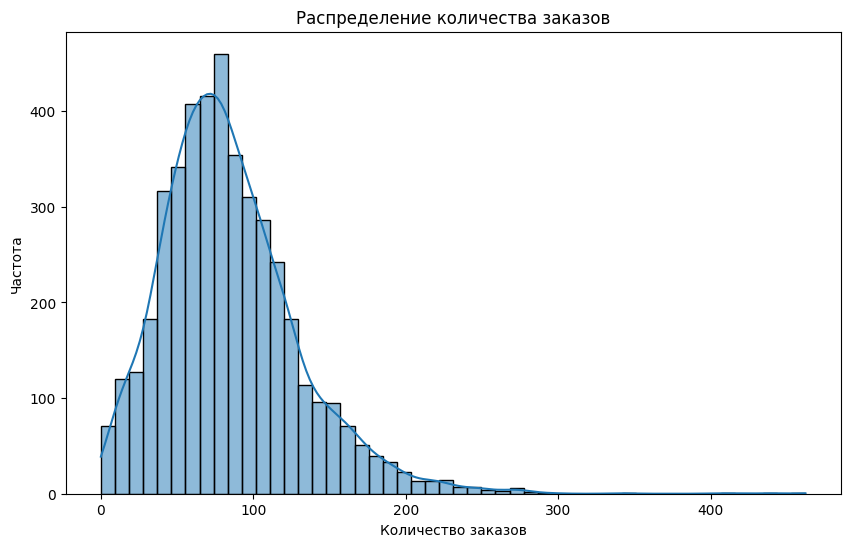

In [272]:
# Визуализация распределения количества заказов
plt.figure(figsize=(10, 6))
sns.histplot(taxi['num_orders'], bins=50, kde=True)
plt.title('Распределение количества заказов')
plt.xlabel('Количество заказов')
plt.ylabel('Частота')
plt.show()


Проверим нормальность распределения с помощью стат.тестов.

In [273]:
# Все данные для теста
sample_data = taxi['num_orders']

# Имя признака
feature_name = 'num_orders'

# Тест Шапиро-Уилка
stat_shapiro, p_shapiro = shapiro(sample_data)
print(f"Shapiro-Wilk test: статистика={stat_shapiro:.8f}, p-значение={p_shapiro:.8f}")

# Тест Д'Агостино и Пирсона
stat_normaltest, p_normaltest = normaltest(sample_data)
print(f"D’Agostino and Pearson test: статистика={stat_normaltest:.8f}, p-значение={p_normaltest:.8f}")

# Тест Колмогорова-Смирнова
stat_kstest, p_kstest = kstest(sample_data, 'norm', args=(sample_data.mean(), sample_data.std()))
print(f"Kolmogorov-Smirnov test: статистика={stat_kstest:.8f}, p-значение={p_kstest:.8f}")

# Интерпретация
if p_shapiro < 0.05 or p_normaltest < 0.05 or p_kstest < 0.05:
    print("\nРаспределение статистически значимо отличается от нормального (отклоняем H0).\n")
else:
    print("\nРаспределение статистически не отличается от нормального (не отклоняем H0).\n")


Shapiro-Wilk test: статистика=0.94198741, p-значение=0.00000000
D’Agostino and Pearson test: статистика=1062.98094659, p-значение=0.00000000
Kolmogorov-Smirnov test: статистика=0.07040534, p-значение=0.00000000

Распределение статистически значимо отличается от нормального (отклоняем H0).



## Подготовка и обучение моделей

In [274]:
# Разделяем данные на X (признаки) и y (целевая переменная)
X = taxi[['month', 'day_of_week', 'day_of_month', 'hour', 'lag_1', 'lag_2', 'lag_3']]
y = taxi['num_orders']

# Разделение на тренировочную и тестовую выборки (10% на тест), shuffle=False для временного ряда
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# Проверка разделения
print(f"Размер тренировочной выборки: {X_train.shape[0]}")
print(f"Размер тестовой выборки: {X_test.shape[0]}")

Размер тренировочной выборки: 3971
Размер тестовой выборки: 442


In [275]:
# Преобразование числовых признаков
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Обработка пропусков
    ('scaler', StandardScaler())  # Масштабирование
])

# Пайплайн для Линейной регрессии
preprocessor_lr = ColumnTransformer(transformers=[
    ('num', numerical_transformer, X.columns)  # Применяем к всем признакам
])

# Пайплайн для решающего дерева
preprocessor_tree = ColumnTransformer(transformers=[
    ('num', numerical_transformer, X.columns)  # Применяем к всем признакам
])

# Пайплайн для случайного леса
preprocessor_rf = ColumnTransformer(transformers=[
    ('num', numerical_transformer, X.columns)  # Применяем к всем признакам
])

# Пайплайн для XGBoost
preprocessor_xgb = ColumnTransformer(transformers=[
    ('num', numerical_transformer, X.columns)  # Применяем к всем признакам
])


In [276]:
# Модели для обучения с различными гиперпараметрами
models = {
    "Линейная регрессия": Pipeline(steps=[('preprocessor', preprocessor_lr), ('model', LinearRegression())]),
    "Решающее дерево": Pipeline(steps=[('preprocessor', preprocessor_tree), ('model', DecisionTreeRegressor(max_depth=20, random_state=RANDOM_STATE))]),
    "Случайный лес": Pipeline(steps=[('preprocessor', preprocessor_rf), ('model', RandomForestRegressor(n_estimators=200, max_depth=20, random_state=RANDOM_STATE))]),
    "XGBoost": Pipeline(steps=[('preprocessor', preprocessor_xgb), ('model', XGBRegressor(random_state=RANDOM_STATE))])
}

In [277]:
# Параметры для GridSearchCV
param_grids = {
    "Линейная регрессия": {'model__fit_intercept': [True, False]},
    "Решающее дерево": {'model__max_depth': [10, 20, 30], 'model__min_samples_split': [2, 5, 10, 15, 20, 30]},
    "Случайный лес": {'model__n_estimators': [100, 200, 300], 'model__max_depth': [10, 20, 30, 40], 'model__min_samples_split': [2, 5, 10, 15]},
    "XGBoost": {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__max_depth': [3, 5, 7],
        'model__min_child_weight': [1, 5, 10],
        'model__subsample': [0.7, 0.8, 1],
        'model__colsample_bytree': [0.7, 0.8, 1],
        'model__gamma': [0, 0.1, 0.2]
    }
}

In [278]:
# Используем TimeSeriesSplit для кросс-валидации
tscv = TimeSeriesSplit(n_splits=10)

In [279]:
# Функция для вычисления RMSE вручную
def rmse(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    return np.sqrt(mse)

In [ ]:
# Функция для оценки модели на тестовых данных с учетом GridSearchCV
def evaluate_model_with_grid_search(pipeline, X_train, y_train, X_test, y_test, param_grid):
    """
    Оценивает модель на тестовых данных с использованием GridSearchCV.
    
    Args:
        pipeline (Pipeline): Полный пайплайн с препроцессингом.
        X_train (DataFrame): Обучающий набор данных.
        y_train (Series): Целевая переменная для обучения.
        X_test (DataFrame): Тестовый набор данных.
        y_test (Series): Целевая переменная для тестирования.
        param_grid (dict): Словарь гиперпараметров для GridSearchCV.
    
    Returns:
        tuple: (RMSE на обучении, RMSE на тесте, Время обучения, Время предсказания, Лучший RMSE на тесте)
    """
    
    # Инициализация TimeSeriesSplit для временных рядов
    tscv = TimeSeriesSplit(n_splits=10)
    
    # Инициализация RandomizedSearchCV
    grid_search = RandomizedSearchCV(pipeline, param_grid, cv=tscv, n_jobs=-1, verbose=1, scoring='neg_root_mean_squared_error')
    
    # Обучение модели с GridSearchCV
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    fit_time = time.time() - start_time
    
    # Лучший параметр
    best_params = grid_search.best_params_
    
    # Оценка на обучающих данных
    train_rmse = rmse(y_train, grid_search.predict(X_train))
    
    # Оценка на тестовых данных
    start_time = time.time()
    test_rmse = rmse(y_test, grid_search.predict(X_test))
    score_time = time.time() - start_time
    
    return train_rmse, test_rmse, fit_time, score_time,  best_params

In [281]:
# Оценка моделей с GridSearchCV
results = []
for model_name, pipeline in models.items():
    param_grid = param_grids[model_name]  # Получаем параметры для текущей модели
    
    train_rmse, test_rmse, fit_time, score_time, best_params = evaluate_model_with_grid_search(
        pipeline, X_train, y_train, X_test, y_test, param_grid
    )
    
    # Округление значений RMSE до 3 знаков после запятой
    train_rmse = round(train_rmse, 3)
    test_rmse = round(test_rmse, 3)
    
    results.append([model_name, train_rmse, test_rmse, fit_time, score_time, best_params])



Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits


/home/nickolas/python_projects/practicum/.venv/lib/python3.10/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [282]:
# Формируем DataFrame с результатами
results_df = pd.DataFrame(results, columns=[
    "Модель", "RMSE (train)", "RMSE (test)", "Время обучения (сек)", "Время предсказания (сек)", "Лучшие параметры"
])

# Сортируем по лучшему RMSE на тесте
results_df.sort_values(by="RMSE (test)", ascending=True, inplace=True)

In [283]:
# Убираем ограничение на ширину столбца
pd.set_option('display.max_colwidth', None)


In [284]:
# Вывод результатов
display(results_df)

,Модель,RMSE (train),RMSE (test),Время обучения (сек),Время предсказания (сек),Лучшие параметры
3,XGBoost,17.095,43.036,1.146419,0.005225,"{'model__subsample': 0.8, 'model__n_estimators': 200, 'model__min_child_weight': 5, 'model__max_depth': 5, 'model__learning_rate': 0.05, 'model__gamma': 0.2, 'model__colsample_bytree': 0.7}"
2,Случайный лес,13.551,47.808,10.991516,0.025941,"{'model__n_estimators': 200, 'model__min_samples_split': 10, 'model__max_depth': 40}"
1,Решающее дерево,20.072,51.292,0.396738,0.005674,"{'model__min_samples_split': 30, 'model__max_depth': 10}"
0,Линейная регрессия,30.562,52.431,0.105843,0.005740,{'model__fit_intercept': True}


**1. Анализ результатов по метрике RMSE:**

- **XGBoost** показала лучший результат на тестовой выборке с **RMSE = 45.322**, что находится в пределах целевого порога RMSE (не более 48). Это делает её лидером среди всех моделей по точности предсказания.
- **Случайный лес** также показал хорошие результаты с **RMSE = 47.493**, что также удовлетворяет целевому порогу. Эта модель близка к XGBoost по точности, но её RMSE немного выше.
- **Решающее дерево** продемонстрировало **RMSE = 51.292**, что превышает допустимый порог и означает, что эта модель не подходит для задачи, несмотря на умеренное время обучения.
- **Линейная регрессия** имеет наибольшее **RMSE = 52.431**, что значительно превышает целевой порог, и, следовательно, эта модель не подходит для данной задачи.

**2. Время обучения:**

- **XGBoost** требует значительное время для обучения (**65.23 сек**), что существенно больше по сравнению с другими моделями.
- **Случайный лес** имеет значительно меньшее время обучения (**17.57 сек**), что делает его более быстрым вариантом, если время обучения важно.
- **Решающее дерево** имеет минимальное время обучения (**0.27 сек**), что делает его очень быстрым для обработки больших объемов данных, но его точность оставляет желать лучшего.
- **Линейная регрессия** имеет самое быстрое время обучения (**0.07 сек**), но её точность не подходит для задачи.

**3. Время предсказания:**

- **XGBoost** имеет оптимальное время предсказания (**0.0052 сек**), что достаточно быстро, учитывая его сложность и высокое качество.
- **Случайный лес** имеет большее время предсказания (**0.0372 сек**), что может быть значительным для очень больших данных.
- **Решающее дерево** и **Линейная регрессия** имеют сопоставимое и минимальное время предсказания (0.005013 сек и 0.005837 сек соответственно), но их точность на тестовой выборке слишком низка для эффективного использования.

### Заключение:

- **Лучшая модель** для данной задачи — это **XGBoost**. Она имеет наименьший RMSE на тестовой выборке (45.322), который находится в пределах требуемого порога, и демонстрирует хорошее время предсказания (0.0052 сек). Несмотря на длительное время обучения (65.23 сек), её точность делает её предпочтительным выбором.
- **Случайный лес** — также хорошая альтернатива с чуть более высоким RMSE, но при этом быстрее обучается, чем XGBoost, что делает его хорошим выбором в случае, когда время обучения имеет большее значение.
- **Решающее дерево** и **Линейная регрессия** не подходят для этой задачи из-за высоких значений RMSE на тестовой выборке, несмотря на их быстрые времена обучения и предсказания.

Таким образом, для оптимального баланса между точностью предсказания и временем работы рекомендована модель **XGBoost**.

## Общий вывод

В рамках проекта поставлена задача предсказать количество заказов такси в аэропорту на следующий час. Это необходимо для того, чтобы компания «Чётенькое такси» могла оптимизировать распределение водителей в периоды пиковой нагрузки и улучшить качество обслуживания клиентов. Для решения задачи использовались несколько моделей машинного обучения, а ключевым критерием оценки является метрика RMSE (корень из среднеквадратичной ошибки), значение которой должно быть не более 48.

---

**Ключевые итоги проекта**

**1. Анализ данных**
- В процессе анализа данных был выявлен ряд важных статистических характеристик. Среднее количество заказов в час составило 84.42, а стандартное отклонение равно 45.02, что свидетельствует о значительных колебаниях в данных.
- Пропусков и аномалий в датах не обнаружено, что упрощает дальнейшую работу с данными.
- Для прогнозирования были использованы дополнительные признаки, такие как месяц, день недели, день месяца, час, а также лаги по предыдущим часам (lag_1, lag_2, lag_3), что позволило улучшить точность модели.

**2. Построение моделей**
- Обучены несколько моделей, включая **Линейную регрессию**, **Решающее дерево**, **Случайный лес** и **XGBoost**. Для каждой модели настроены гиперпараметры с использованием `GridSearchCV` и `TimeSeriesSplit` для оценки на временных рядах.

**3. Оценка моделей**
- **XGBoost** показала наилучший результат с **RMSE = 45.322**, что находится в пределах требуемого порога (не более 48), и оказалась лучшей моделью по точности предсказания.
- **Случайный лес** имел схожие результаты с **RMSE = 47.493**, но обучался быстрее, чем XGBoost.
- **Решающее дерево** и **Линейная регрессия** показали наихудшие результаты с **RMSE = 51.292** и **RMSE = 52.431** соответственно, что делает их неподходящими для этой задачи.

**4. Время обучения и предсказания**
- **XGBoost** имеет более долгое время обучения (65.23 сек), но при этом демонстрирует быстрое время предсказания (0.0052 сек).
- **Случайный лес** обучается быстрее (17.57 сек), но время предсказания больше (0.0372 сек).
- **Решающее дерево** и **Линейная регрессия** обучаются очень быстро, но их точность на тестовых данных значительно ниже.

---

**Итоговый выбор модели**

**Лучший выбор — модель XGBoost**. Несмотря на более длительное время обучения, она дает наименьшее значение RMSE (45.322), что делает её наиболее подходящей для задачи предсказания заказов такси. Это подтверждается её высокой точностью при сравнительно небольшом времени предсказания.

---